# Distance Indicator

Here we create an predictor that is defined as the geographic (as the crow flies) distance between The Bachelor's hometown and each contestant

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import json
from geopy import geocoders
import math

In [3]:
#Import seasonsDict.json which contains hometown information
with open("tempdata/listAllDicts.json") as json_file:
    seasons = json.load(json_file)


Here get the hometown information from each candidate

In [4]:
#Make a function that get's contestant's hometown for a given season
#Update known errors in the dictionary
def get_hometowns(choose_season):
    town_dict = {}
    for idict in seasons:
        if idict["season"] == choose_season:
            if idict["elimination"] == "bachelor":
                bachtown = idict["hometown"]
            else:
                if idict["name"] == "Kacie Boguskie":
                    idict["hometown"] = "Clarksville, Tennessee"
                town_dict.update({idict['name']:idict['hometown']})
    return bachtown, town_dict


We use a function that computes the distance between two points on a sphere, which follows the following equation:

$$ \cos(arc length) = \cos{\phi_1}\cos{\phi_2} + \sin{\phi_1}\sin{\phi_2}\cos{(\theta_1 - \theta_2)}$$

We then multiply the arc length by the radius of the Earth to get the distance.

In [5]:
#Create a function to compute distance between two lat/lon points on Earth
#Borrows heavily from http://www.johndcook.com/blog/python_longitude_latitude/ 
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    
    Rearth = 3959 #in miles
 
    return arc * Rearth

To convert hometowns in (city, state) format, we use the python package "geopy" which accepts input in our format, and returns the lat/lon coordinates of the center of town. 

In [6]:
#Make function that gets distance between contestant and Bachelor
def get_contest_distance(hometown_output):
    bach_home, c_home = hometown_output
    
    #Use geopy package to get lat/lon from location
    gn = geocoders.Nominatim()
    
    #Get the Bachelor location
    bhome = gn.geocode(bach_home)
    blat = float(bhome.raw["lat"])
    blon = float(bhome.raw["lon"])

    #Find distance between bachelor and contestant distances
    distance_dict = {}
    for contestant in c_home.keys():
        chome = gn.geocode(c_home[contestant])
        clat = float(chome.raw["lat"])
        clon = float(chome.raw["lon"])

        #Find distance
        distance_apart = distance_on_unit_sphere(blat, blon, clat, clon)

        distance_dict.update({contestant: distance_apart})

    return distance_dict
    

Run over all seasons and save the output as a dictionary

In [8]:
season_nums = range(13,20)

#Run over all seasons
distance_dict = {}
for season_num in season_nums:
    distance_dict.update({season_num: get_contest_distance(get_hometowns(season_num))})
    print "season ", season_num, " done"


season  13  done
season  14  done
season  15  done
season  16  done
season  17  done
season  18  done
season  19  done


In [9]:
with open('distances.json', 'w') as fp:
    json.dump(distance_dict, fp)

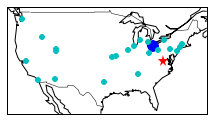

In [100]:
#from mpl_toolkits.basemap import Basemap

#Make a function that maps hometowns.
#NOTE: Only maps continental US.  No known contestants/bachelors from HI, Alaska, etc.
#
#input:
#     hometown   = get_hometown() output (bach hometown and dict of contestant hometowns)
#     subplotNum = position on grid of plots
#     winnerTownNum = index of 'winnertowns' array (array of winners' hometowns)

def make_maps(hometown_output, subplotNum, winnerTownNum):
    bachelor_home, contestant_home = hometown_output
    
    #add new subplot of USA
    ax=fig.add_subplot(subplotnum)
    m = Basemap(projection='merc',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-127,urcrnrlon=-65,lat_ts=20,resolution='c')
    m.drawmapboundary(fill_color='none')
    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    
    #Use geopy package to get lat/lon from location
    gn = geocoders.Nominatim()
    
    #Get the Bachelor location
    bachHome = gn.geocode(bachelor_home)
    bachLat = float(bachHome.raw["lat"])
    bachLon = float(bachHome.raw["lon"])
    
    #put a big blue circle on Bachelor's hometown
    x,y = m(bachLon, bachLat)
    m.plot(x,y, 'bo')

    #for each contestant in this season, put a little cyan dot
    for contestant in contestant_home.keys():
        contHome = gn.geocode(contestant_home[contestant])
        contLat = float(contHome.raw["lat"])
        contLon = float(contHome.raw["lon"])
    
        #put a dot on Contestant's hometown
        xpt,ypt = m(contLon, contLat)
        m.plot(xpt, ypt, 'c.')
        
    #put a red star on winner's hometown
    winnerHome = gn.geocode(winnertowns[winnerTownNum])
    winnerLat = float(winnerHome.raw["lat"])
    winnerLon = float(winnerHome.raw["lon"])
        
    wx,wy = m(winnerLon, winnerLat)
    m.plot(wx, wy, 'r*')


#http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.plot

GeocoderTimedOut: Service timed out

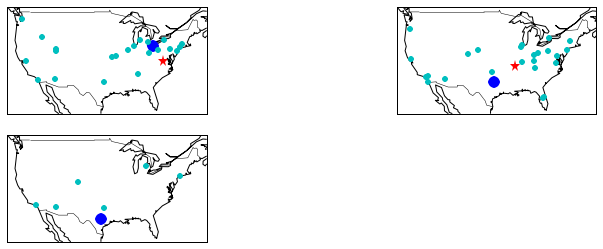

In [102]:
#Make Array of winners' hometowns
winnertowns = []
for sdict in seasons:
    if sdict["elimination"] == "bachelor":
        winnertowns.append(sdict["hometown"])

fig = plt.figure()  
subplotnum = 421    #4=numrows, 2=num cols, 1=starting axis to use
numWinnerTown = 0

#for each season, plot hometowns
for seasonnum in season_nums:
    make_maps(get_hometowns(seasonnum), subplotnum, numWinnerTown)
    subplotnum += 1
    numWinnerTown += 1